In [1]:
from langchain_chroma import Chroma
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
load_dotenv(override=True)
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters.character import RecursiveCharacterTextSplitter
import os

## Ingestion

In [2]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
loader = WebBaseLoader(urls)
text_docs = loader.load()
doc_corpus = "\n---\n".join([i.page_content for i in text_docs])
splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250, chunk_overlap=0)
documents = splitter.split_documents(text_docs)
chroma_db = Chroma.from_documents(documents=documents,
                                  collection_name="ai_docs", 
                                  embedding = OpenAIEmbeddings(model="text-embedding-ada-002"), 
                                  persist_directory=".")

## Graph State

In [2]:
from typing import TypedDict, List

In [3]:
class customGraph(TypedDict):

    """
    Represents the state of the graph

    Attributes:
        question: Question
        generation: LLM Generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

## Retrieve Node

#### Load VectorDB

In [4]:
vector_db = Chroma(collection_name = "ai_docs",
                   persist_directory=".",
                   embedding_function=OpenAIEmbeddings(model="text-embedding-ada-002")).as_retriever()

#### Retriever

In [5]:
from typing import Dict, Any

In [6]:
def retriver_process(state: customGraph) -> Dict[str, Any]:
    question = state['question']
    docs = vector_db.invoke(question)
    return {"question": question, "documents": docs}

## Grade Document

#### Retrieval Grader Testing

In [7]:
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import JsonOutputParser, PydanticOutputParser

In [8]:
class GradeDocument(BaseModel):
    """
    Binary score for relevance check on retrievedd document.
    """
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

structured_llm = ChatOpenAI(model="gpt-4o", temperature=0.).with_structured_output(GradeDocument)

In [9]:
system_msg = """
You are a grader assessing relevance of a retrieved document to a user question. 
If the document conatins keyword(s) or semantic menaing related to the question, grade it as relevant.
Give it a bonary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_msg), 
        ("human", "Retrieved Document: \n\n {documents} \n\n User Question: {question}")
    ]
)

retrieval_grader = grade_prompt | structured_llm

In [10]:
query_passed = "agent memeory"
docs = vector_db.invoke(query_passed)
print(f"Document Relevance Flag: {retrieval_grader.invoke({"documents": docs[0], "question": query_passed}).binary_score}")

Document Relevance Flag: yes


In [11]:
query_passed = "bake a cake"
docs = vector_db.invoke(query_passed)
print(f"Document Relevance Flag: {retrieval_grader.invoke({"documents": docs[0], "question": query_passed}).binary_score}")

Document Relevance Flag: no


#### Retrieval Grader Function

In [12]:
def grade_documents(state: customGraph):
    """
    Grades the retrieved documents and invokes the websearch flag if required
    """
    question = state["question"]
    docs = state["documents"]
    filtered_msgs = []
    websearch_flag = False

    for doc in docs:
        relevant_flag = retrieval_grader.invoke({"documents": doc, "question": query_passed}).binary_score
        if relevant_flag == "yes":
            filtered_msgs.append(doc)
        else:
            websearch_flag = True

    return {"question" : question, "documents" : filtered_msgs, "web_search": websearch_flag}

## Websearch Tool

In [13]:
from langchain_tavily import TavilySearch
from langchain_core.documents.base import Document

In [14]:
search = TavilySearch(max_results = 3)

In [15]:
def websearch_tool(state: customGraph):
    """
    This function invokes the websearch for the question if the web_search flag in the GraphState is True
    """
    question = state["question"]
    documents = state["documents"]
    
    search_results = search.invoke({"query": question})

    web_results = Document(page_content = "\n---\n".join([res["content"] for res in search_results["results"]]))

    if documents:
        documents.append(web_results)
    else:
        documents = [web_results]
        
    return {"question": question, "documents": documents}

In [16]:
sample_websearch_node = websearch_tool(state = {"question": "agent memory", "documents": None})

In [46]:
#print(sample_websearch_node["documents"][0].page_content)

## Generation Chain

In [17]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

In [18]:
prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model="gpt-4o")
generation_chain = prompt | llm | StrOutputParser()

In [19]:
question = "agent_memory"
generation_chain.invoke({"question": question, "context": retriver_process(state={"question": question})})

'In an LLM-powered autonomous agent system, memory is categorized into short-term and long-term functions. Short-term memory involves in-context learning from the prompt, while long-term memory allows the agent to retain and recall extensive information over time by using external vector stores for fast retrieval. This memory framework, along with planning and tool use, forms the core of such agents.'

In [39]:
def generation_node(state: customGraph):
    """
    This creates the RAG Generation for the input question
    """
    question = state["question"]
    docs = state["documents"]
    retrieved_results = generation_chain.invoke({"question": question, "context": docs})
    return {"question": question, "generation": retrieved_results, "documents": docs}

## Building Node

In [21]:
from langgraph.graph import StateGraph, START, END

In [22]:
graph = StateGraph(state_schema = customGraph)

In [23]:
graph.add_node("retrieve", retriver_process)

In [24]:
graph.add_node("grade_retrievedDocs", grade_documents)

In [25]:
graph.add_node("use_web", websearch_tool)

In [26]:
graph.add_node("generate_finalResult", generation_node)

## Add Edges

In [27]:
graph.add_edge(START, "retrieve")

In [28]:
graph.add_edge("retrieve", "grade_retrievedDocs")

In [29]:
def decide_websearch(state: customGraph):

    if state["web_search"]:
        return "trigger_webSearch"

    else:
        return "trigger_generation"

In [30]:
graph.add_conditional_edges("grade_retrievedDocs", 
                            decide_websearch, 
                            {
                                "trigger_webSearch": "use_web",
                                "trigger_generation": "generate_finalResult"
                            })

In [31]:
graph.add_edge("use_web", "generate_finalResult")

In [32]:
graph.add_edge("generate_finalResult", END)

In [33]:
flow = graph.compile()

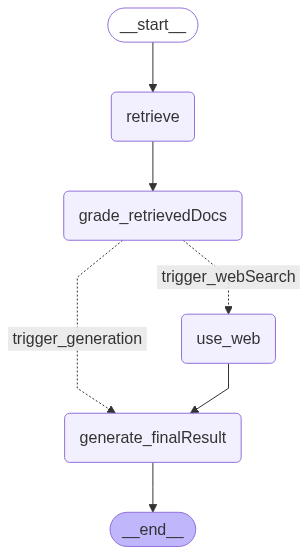

In [34]:
flow

In [37]:
result = flow.invoke({"question":"Bake a cake"})

In [38]:
result

{'question': 'Bake a cake',
 'generation': "To bake a plain cake, you'll need basic baking ingredients like flour, sugar, eggs, salt, milk, and baking powder. Follow a step-by-step recipe to guide you through the process, and consider exploring cake decorating techniques for a professional finish. For keeping the cake fresh and moist, use Japanese baking techniques that help maintain moisture for several days.",
 'web_search': True,
 'documents': [Document(metadata={}, page_content="A plain cake is a simple dessert that's easy to make at home—all you need is some basic baking ingredients like flour, sugar, eggs, salt, milk, and baking powder. In this article, we'll teach you exactly how to bake a plain cake recipe step by step so you can quickly and easily throw together a tasty treat that your friends and family are sure to enjoy.\n---\nLearn how to bake a cake with our step-by-step overview. We'll share all our best tips, the prettiest cake decorating techniques, and answers to commo

In [28]:
sample = search.invoke({"query":"What is India foreign national policy"})

In [37]:
for i in sample['results']:
    print(i.content)
    break

AttributeError: 'dict' object has no attribute 'content'

In [27]:
output.binary_score

'yes'

In [25]:
output = retrieval_grader.invoke({"documents": doc, "question": query_passed})

In [176]:
output.model_dump()

{'binary_score': 'no'}

In [119]:
output = structured_llm.invoke(grade_prompt.format(document = docs[0], question = query_passed))

In [127]:
output_parser = PydanticOutputParser(pydantic_object = GradeDocument)
output_parser.invoke(output)

ValidationError: 1 validation error for Generation
text
  Input should be a valid string [type=string_type, input_value=GradeDocument(binary_score='yes'), input_type=GradeDocument]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type

In [117]:
print(grade_prompt.format(document = docs[0], question = query_passed))

System: 
You are a grader assessing relevance of a retrieved document to a user question. 
If the document conatins keyword(s) or semantic menaing related to the question, grade it as relevant.
Give it a bonary score 'yes' or 'no' score to indicate whether the document is relevant to the question.

Human: Retrieved Document: 

 page_content='Nlp
Language-Model
Alignment
Steerability
Prompting



« 

LLM Powered Autonomous Agents


 »

The Transformer Family Version 2.0






































© 2025 Lil'Log

        Powered by
        Hugo &
        PaperMod' metadata={'language': 'en', 'title': "Prompt Engineering | Lil'Log", 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods

In [ ]:
def retrieval_grader(state: GraphState):
    

In [102]:
documents

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [83]:
Any.mro()

[typing.Any, object]

In [72]:
vector_db.

In [64]:
import os
os.getcwd()

'/Users/A118390615/Library/CloudStorage/OneDrive-DeutscheTelekomAG/Projects/COE_Projects/langgraph_course_1/agentic_rag'

In [60]:
len(documents)

47

In [62]:
documents[0].dict()

/var/folders/xg/ffmlt01s6576w5wrhsp6ljqh0000gq/T/ipykernel_68708/2731802841.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  documents[0].dict()


{'id': None,
 'metadata': {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
  'title': "LLM Powered Autonomous Agents | Lil'Log",
  'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of

In [63]:
documents[1].dict()

/var/folders/xg/ffmlt01s6576w5wrhsp6ljqh0000gq/T/ipykernel_68708/1390656886.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  documents[1].dict()


{'id': None,
 'metadata': {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
  'title': "LLM Powered Autonomous Agents | Lil'Log",
  'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of

In [48]:
documents[2].dict()

/var/folders/xg/ffmlt01s6576w5wrhsp6ljqh0000gq/T/ipykernel_68708/4106897149.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  documents[2].dict()


{'id': None,
 'metadata': {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
  'title': "LLM Powered Autonomous Agents | Lil'Log",
  'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of